## Подготовка

Импортируем необходимые библиотеки для работы с проектом.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, Pool

Откроем датасет и просмотрим общую информацию и описательную статистику.

In [2]:
data = pd.read_csv('/datasets/taxi.csv')
data.info()
display(data.head())
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32

num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

Измении тип данных datetime с object на datetime64. Проверим, в хронологическом ли порядке расположены даты и время через атрибут is_monotonic. Если порядок соблюдён, атрибут вернёт True, если нет — False.

In [3]:
data["datetime"] = data["datetime"].astype("datetime64")
data = data.set_index('datetime')
if data.index.is_monotonic == True:
    print('Порядок соблюден')
else:
    print('Порядок не соблюден')

Порядок соблюден


Проверим изменение типа данных datetime с object на datetime64.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Определим наличие пропусков в датасете.

In [5]:
data.isna().sum()

num_orders    0
dtype: int64

С помощью аргумента resample() проведем ресемплирование по одному часу, а также для агрегации количества заказаов за каждый час вызовем аргумент sum() для суммирования количество заказов за каждый час.

In [6]:
data = data.resample('1H').sum()

In [7]:
data.head()

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

Text(0.5, 1.0, 'График количества заказов в час с марта по август')

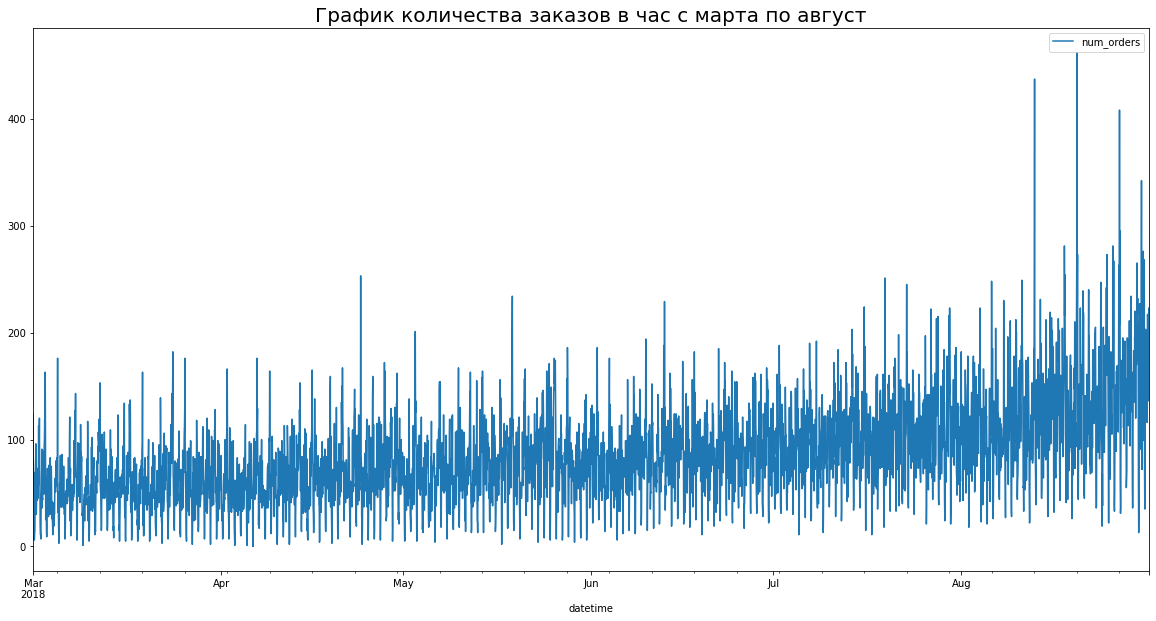

In [8]:
data.plot(figsize=(20, 10))
plt.title("График количества заказов в час с марта по август",
          fontsize = 20)

<b>Вывод по п.1:</b>
<br>На данном этапе был подготовлен датасет для анализа и дальнейшего обучения моделей. Было проведено изменения типа данных признака datatime с object на datetime64. Была проведена проверка хронологического порядка датасета. Также было проведено ресемплирование по одному часу и для агрегации значений просуммировано количество заказов за каждый час.

## Анализ

Для анализа временного ряда воспользуемся такими индикаторами, как "скользящее среднее", тренды и сезонность и разности временного ряда.  

График индикатора скользящее среднее.

Text(0.5, 1.0, 'График количества заказов в час с скользящей средней')

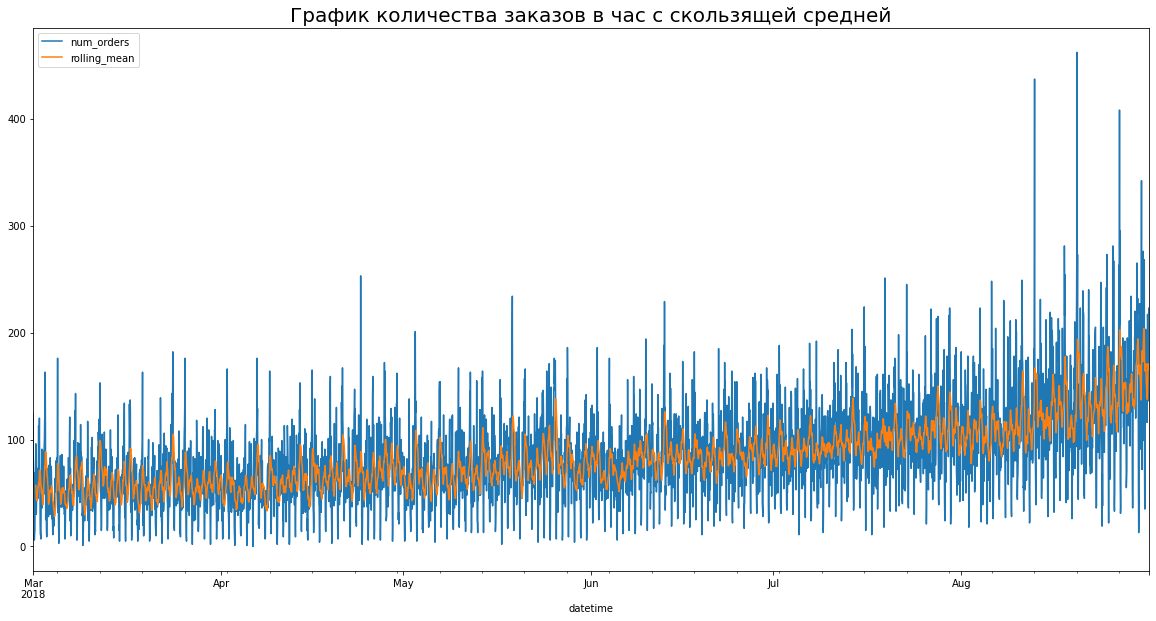

In [9]:
data['rolling_mean'] = data.rolling(12).mean()
data.plot(figsize=(20, 10))
plt.title("График количества заказов в час с скользящей средней",
          fontsize = 20)

Графики тренда, сезонности и остатка декомпозиции.

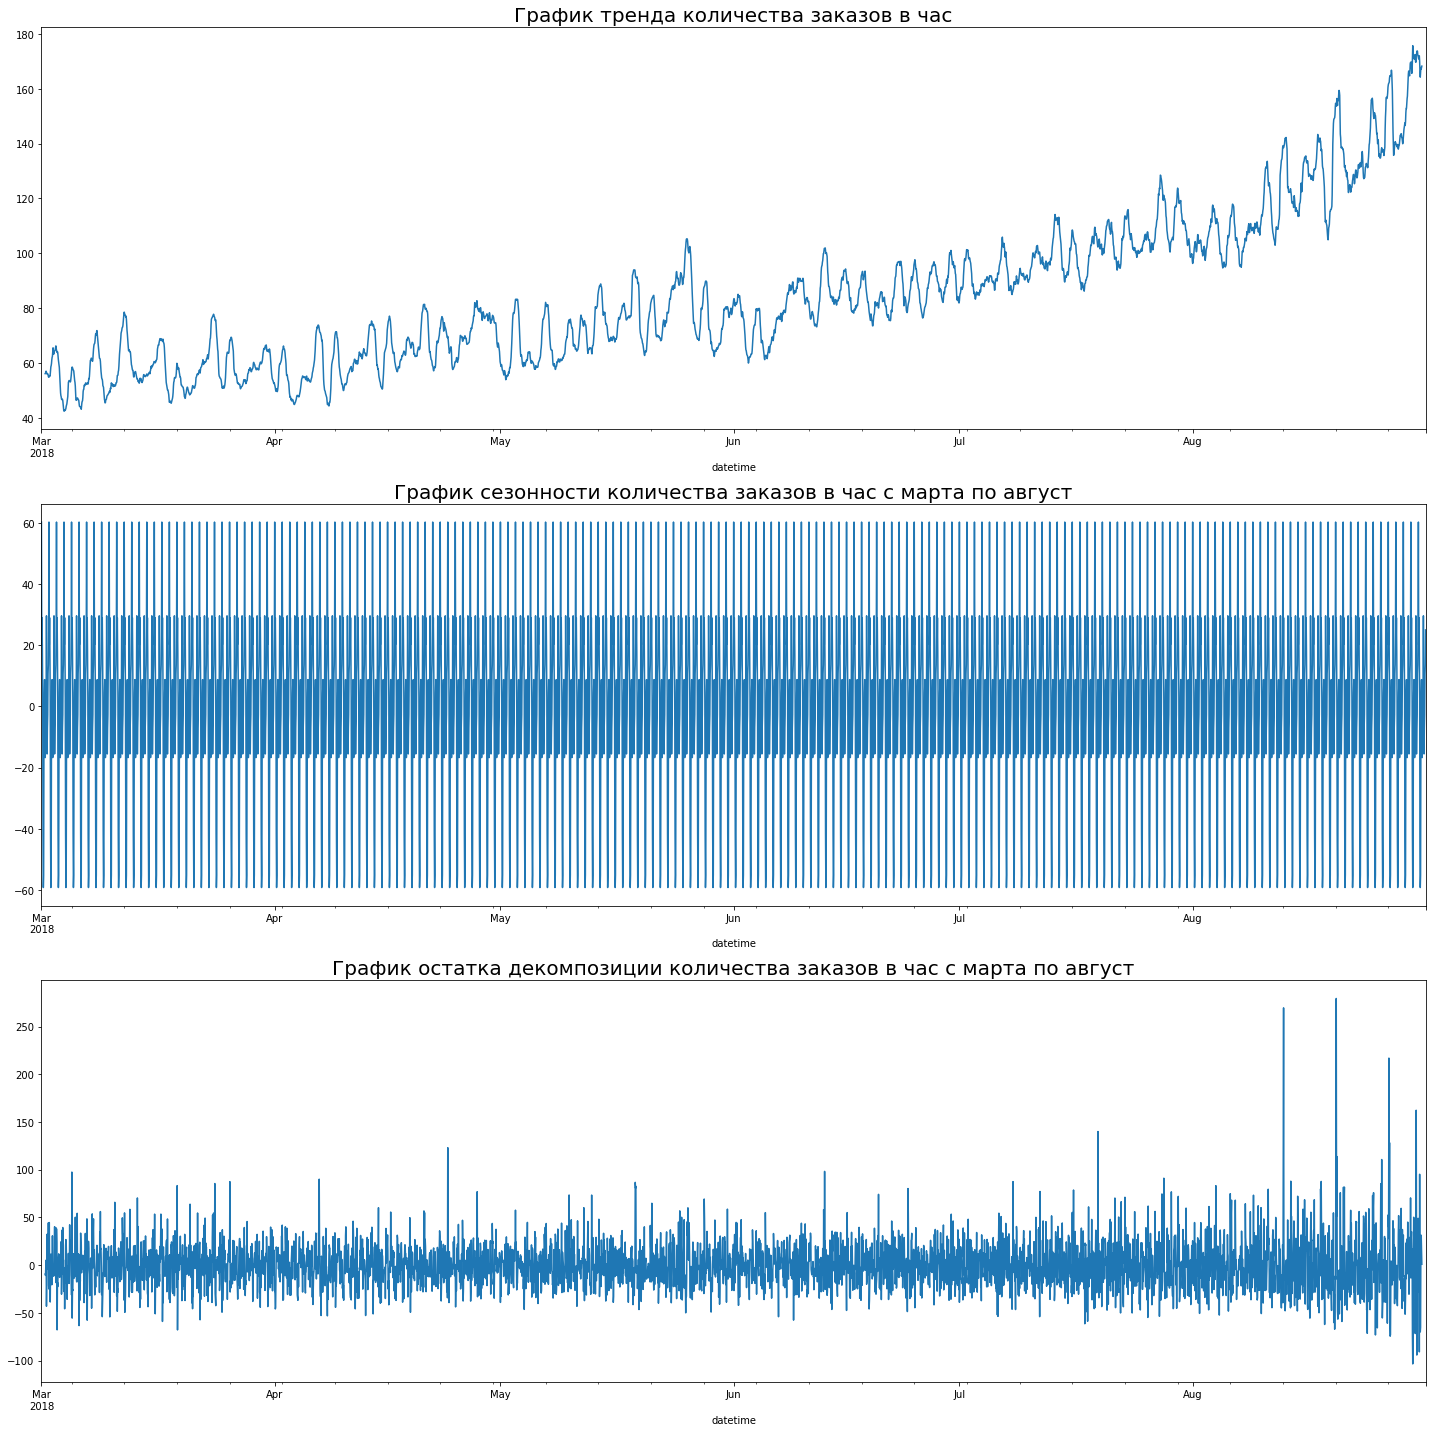

In [10]:
data = data.drop(['rolling_mean'], axis = 1)

decomposed = seasonal_decompose(data) 

plt.figure(figsize = (20, 20))
plt.subplot(311)
decomposed.trend.plot(ax = plt.gca())
plt.title('График тренда количества заказов в час',
          fontsize = 20)
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('График сезонности количества заказов в час с марта по август',
          fontsize = 20)
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('График остатка декомпозиции количества заказов в час с марта по август',
          fontsize = 20)
plt.tight_layout()

Рассмотрим графики тренда, сезонности и остатка декомпозиции при ресемплировании в длительность 1 день.

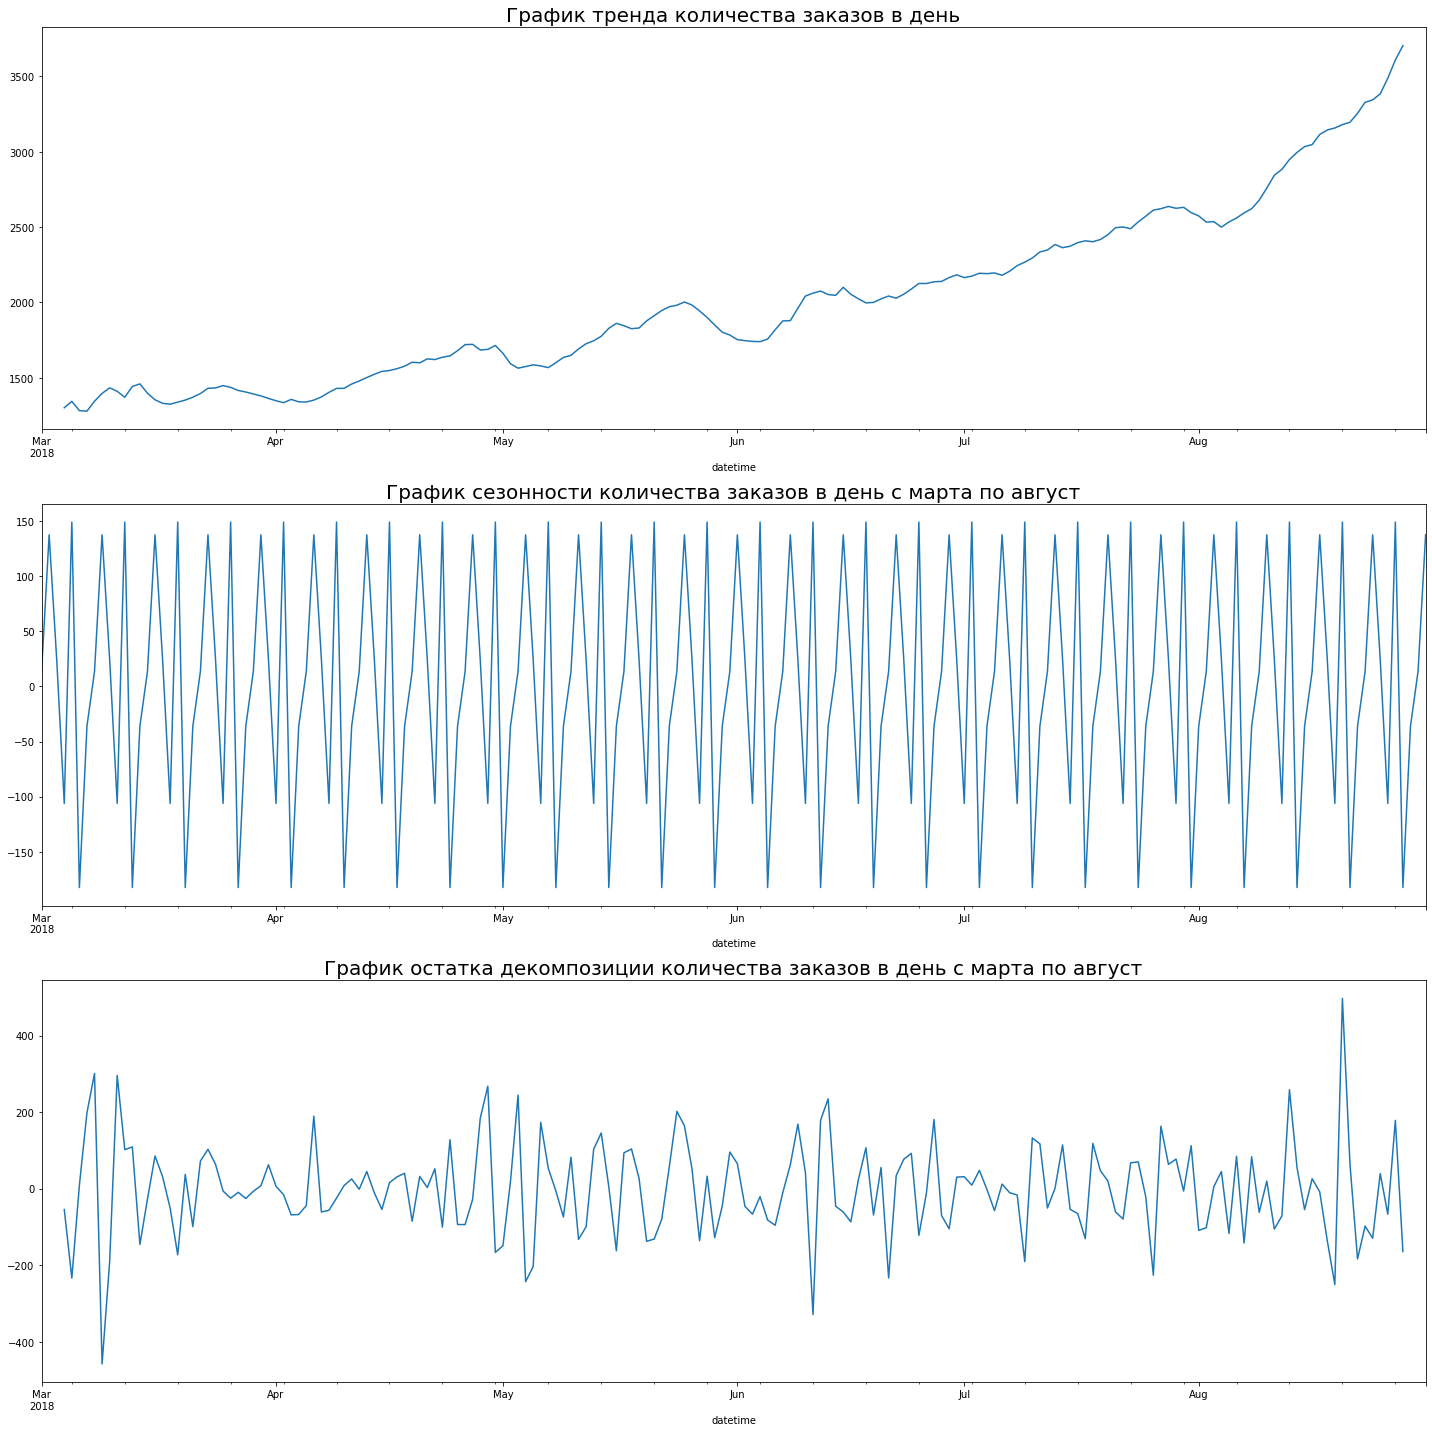

In [11]:
data_week = data.resample('1D').sum()

decomposed = seasonal_decompose(data_week) 

plt.figure(figsize = (20, 20))
plt.subplot(311)
decomposed.trend.plot(ax = plt.gca())
plt.title('График тренда количества заказов в день',
          fontsize = 20)
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('График сезонности количества заказов в день с марта по август',
          fontsize = 20)
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('График остатка декомпозиции количества заказов в день с марта по август',
          fontsize = 20)
plt.tight_layout()

График разности временного ряда.

Text(0.5, 1.0, 'График разности временного ряда.')

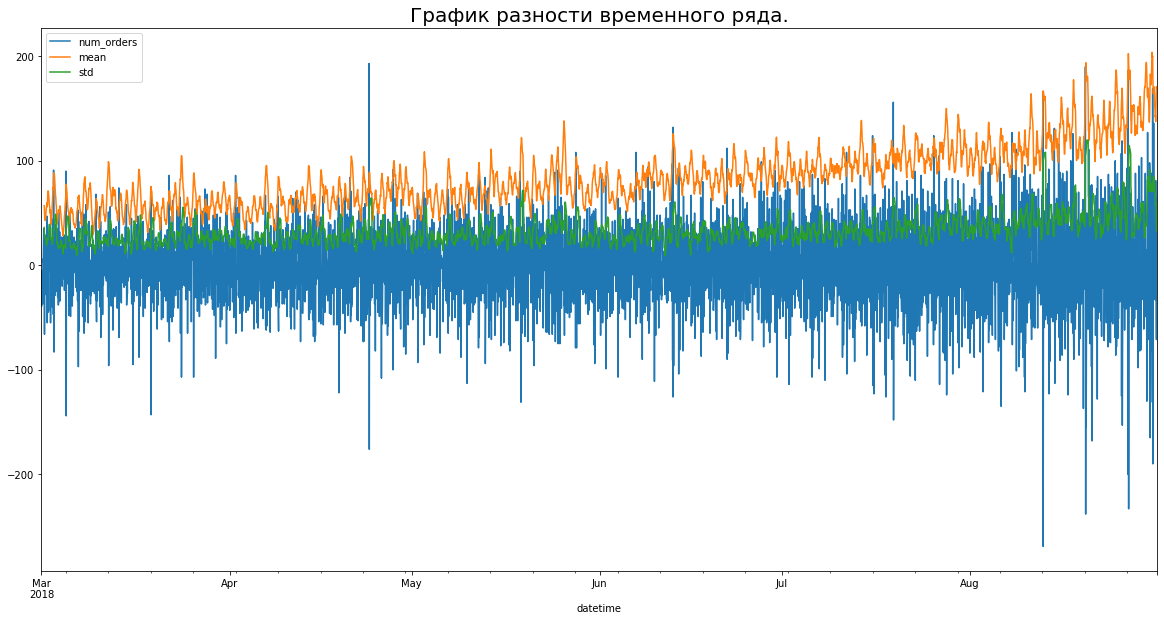

In [12]:
data_shift = data - data.shift()
data_shift['mean'] = data['num_orders'].rolling(12).mean()
data_shift['std'] = data['num_orders'].rolling(12).std()
data_shift.plot(figsize=(20, 10))
plt.title('График разности временного ряда.',
          fontsize = 20)

<b>Вывод по п.2:</b>
<br>Анализируя график скользящей средней, а также график 'trend' можно сделать вывод, что от марта к августу количество заказов становится больше. Пиковое количество заказов приходится на август, но также пиковые значения есть и в другие дни. Также данную тенденцию к увеличению заказов подтверждают графики с разностями временного ряда. Была дополнительно исследована недельная сезонность с помощью ресемплирования по дням. На ней также наблюдается увеличение от марта к августу. Также стоит отметить, что увеличение "остатков" к концу графика, что видет к увеличению количества данных в тестовой выборке.  

## Обучение

Для обучения создадим дополнительные признаки, а также разделим выборку на тренировочную и тестовую так, чтобы тестовая выборка составляла 10% от полной выборки.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['week'] = data.index.week
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 40, 12)

/tmp/ipykernel_179/2745842519.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['week'] = data.index.week


In [14]:
train, test = train_test_split(data, shuffle=False, test_size = 0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

Обучим модель LinearRegression() и рассчитаем метрику RMSE.

In [15]:
model = LinearRegression()

tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(model, features_train, target_train, cv=tscv, scoring = 'neg_root_mean_squared_error') 

final_score = sum(scores[1:len(scores)]) / (len(scores) - 1)
rmse_lr = - final_score

print('Средняя оценка качества модели:', - final_score)
print(scores)

Средняя оценка качества модели: 27.292959747620785
[-2.35920616e+08 -2.35563525e+01 -2.50019954e+01 -2.72584922e+01
 -3.33549989e+01]


Подберем оптимальные параметры модели DecisionTreeRegressor, поставив метрику RMSE для оценки.

In [16]:
dtr = DecisionTreeRegressor(random_state=12345)
parametrs = { 'max_depth': range (1,6),
              'min_samples_split': range (2,10,2),
              'min_samples_leaf': range(2,10, 2)}
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(dtr, parametrs, cv=tscv, n_jobs=-1, verbose=10, scoring = 'neg_root_mean_squared_error')
grid.fit(features_train, target_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5; 1/80] START max_depth=1, min_samples_leaf=2, min_samples_split=2.......
[CV 1/5; 1/80] END max_depth=1, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV 2/5; 1/80] START max_depth=1, min_samples_leaf=2, min_samples_split=2.......
[CV 2/5; 1/80] END max_depth=1, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV 3/5; 1/80] START max_depth=1, min_samples_leaf=2, min_samples_split=2.......
[CV 3/5; 1/80] END max_depth=1, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV 4/5; 1/80] START max_depth=1, min_samples_leaf=2, min_samples_split=2.......
[CV 4/5; 1/80] END max_depth=1, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV 5/5; 1/80] START max_depth=1, min_samples_leaf=2, min_samples_split=2.......
[CV 5/5; 1/80] END max_depth=1, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV 1/5; 2/80] START max_depth=1, min_samples_leaf=2, min_samples_split=4

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'min_samples_leaf': range(2, 10, 2),
                         'min_samples_split': range(2, 10, 2)},
             scoring='neg_root_mean_squared_error', verbose=10)

Определим наилучшие параметры DecisionTreeRegressor и соответствующее им значание RMSE.

In [17]:
rmse_dtr = - grid.best_score_
best_param_dtr = grid.best_params_
print('Наилучшие параметры модели DecisionTreeRegressor:', best_param_dtr)
print('Наилучшее значение RMSE обучающей выборки модели DecisionTreeRegressor:', rmse_dtr)

Наилучшие параметры модели DecisionTreeRegressor: {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}
Наилучшее значение RMSE обучающей выборки модели DecisionTreeRegressor: 29.721835472800386


Подберем оптимальные параметры для модели CatBoostRegressor.

In [18]:
cb = CatBoostRegressor(random_state=12345)
parametrs = { 'depth': range (1, 6),
              'n_estimators': range (100, 500, 100),
              'leaf_estimation_iterations': range (100, 500, 100)}
grid = GridSearchCV(cb, parametrs, cv = tscv, n_jobs = -1, verbose = 10, scoring = 'neg_root_mean_squared_error')
grid.fit(features_train, target_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5; 1/80] START depth=1, leaf_estimation_iterations=100, n_estimators=100..
0:	learn: 29.3395728	total: 48.6ms	remaining: 4.81s
1:	learn: 29.1439589	total: 49.8ms	remaining: 2.44s
2:	learn: 28.9714991	total: 50.8ms	remaining: 1.64s
3:	learn: 28.7355478	total: 52.1ms	remaining: 1.25s
4:	learn: 28.5030107	total: 53.4ms	remaining: 1.01s
5:	learn: 28.2838747	total: 54.5ms	remaining: 853ms
6:	learn: 28.1562732	total: 55.4ms	remaining: 736ms
7:	learn: 27.9672588	total: 56.7ms	remaining: 652ms
8:	learn: 27.8129157	total: 57.8ms	remaining: 584ms
9:	learn: 27.6239182	total: 59.1ms	remaining: 532ms
10:	learn: 27.4698290	total: 60.3ms	remaining: 488ms
11:	learn: 27.3344759	total: 61.2ms	remaining: 449ms
12:	learn: 27.2038022	total: 62.2ms	remaining: 416ms
13:	learn: 27.0617559	total: 63.1ms	remaining: 388ms
14:	learn: 26.9483424	total: 64ms	remaining: 363ms
15:	learn: 26.8095646	total: 65ms	remaining: 341ms
16:	learn: 26.6782412	t

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f13737d0400>,
             n_jobs=-1,
             param_grid={'depth': range(1, 6),
                         'leaf_estimation_iterations': range(100, 500, 100),
                         'n_estimators': range(100, 500, 100)},
             scoring='neg_root_mean_squared_error', verbose=10)

Определим наилучшие параметры CatBoostRegressor и соответствующее им значание RMSE.

In [19]:
rmse_cb = - grid.best_score_
best_param_cb = grid.best_params_
print('Наилучшие параметры модели DecisionTreeRegressor:', best_param_cb)
print('Наилучшее значение RMSE обучающей выборки модели DecisionTreeRegressor:', rmse_cb)

Наилучшие параметры модели DecisionTreeRegressor: {'depth': 5, 'leaf_estimation_iterations': 100, 'n_estimators': 400}
Наилучшее значение RMSE обучающей выборки модели DecisionTreeRegressor: 24.476882802068033


Создадим датасет со значениями RMSE для трех моделей и определим лучшую.

In [20]:
df = pd.DataFrame({'Название модели': ['LinearRegression', 'DecisionTreeRegressor', 'CatBoostRegressor'],
                   'Параметры модели' : ['', best_param_dtr, best_param_cb],
                   'RMSE': [rmse_lr, rmse_dtr, rmse_cb]})
display(df)

Название модели                                   Параметры модели  \
0       LinearRegression                                                      
1  DecisionTreeRegressor  {'max_depth': 5, 'min_samples_leaf': 8, 'min_s...   
2      CatBoostRegressor  {'depth': 5, 'leaf_estimation_iterations': 100...   

        RMSE  
0  27.292960  
1  29.721835  
2  24.476883

Наилучшее значение RMSE получилось у модели CatBoostRegressor. 

<b>Вывод по п.3:</b>
<br>В данном пунтке были проверены три модели: LinearRegressor, DecisionTreeRegressor и CatBoostRegressor. Для моделей DecisionTreeRegressor и CatBoostRegressor были подобраны оптимальные параметры. После проверки на тренировочной выборке наилучшее значение метрики RMSE получила модель CatBoostRegressor, которую мы проверим на тестовой выборке.

## Тестирование

Проверим модель CatBoostRrgressor на тестовой выборке.

In [21]:
cb = CatBoostRegressor(depth = 5, 
                       leaf_estimation_iterations = 100,
                       n_estimators = 400)

pool_test = Pool(features_test, target_test)
pool_train = Pool(features_train, target_train)
cb.fit(pool_train, verbose=30) 
predictions = cb.predict(features_test)
rmse_cb = mean_squared_error(target_test, predictions) ** 0.5
print("RMSE тестовой выборки модели CatBoostRegressor:", rmse_cb)

0:	learn: 38.1302781	total: 8.4ms	remaining: 3.35s
30:	learn: 28.4115709	total: 303ms	remaining: 3.6s
60:	learn: 25.0462428	total: 595ms	remaining: 3.31s
90:	learn: 23.5520061	total: 941ms	remaining: 3.19s
120:	learn: 22.6555839	total: 1.24s	remaining: 2.85s
150:	learn: 21.8966244	total: 1.52s	remaining: 2.5s
180:	learn: 21.3770900	total: 1.8s	remaining: 2.18s
210:	learn: 20.9800911	total: 2.1s	remaining: 1.88s
240:	learn: 20.5749392	total: 2.41s	remaining: 1.59s
270:	learn: 20.1526811	total: 2.73s	remaining: 1.3s
300:	learn: 19.7394807	total: 3.03s	remaining: 997ms
330:	learn: 19.3615447	total: 3.34s	remaining: 696ms
360:	learn: 18.9721387	total: 3.65s	remaining: 395ms
390:	learn: 18.6309249	total: 3.98s	remaining: 91.7ms
399:	learn: 18.5258431	total: 4.1s	remaining: 0us
RMSE тестовой выборки модели CatBoostRegressor: 40.88839573115585


In [22]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
rmse_pred = mean_squared_error(target_test, pred_previous) ** 0.5
print('RMSE между pred_previous и target_test:', rmse_pred)

RMSE между pred_previous и target_test: 58.856486242815066


Как можно заметить RMSE меньше необходимого значения, 48. Данное значения было получено путем изменения значений max_lag и rolling_mean_size при создании новых признаков.